<a href="https://colab.research.google.com/github/imnaimur/cse428/blob/main/project/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets,transforms
from pathlib import Path
from PIL import Image

##Data preperations

In [2]:
# Install kagglehub
# !pip install kagglehub

import kagglehub

# Download latest version
path = kagglehub.dataset_download("briscdataset/brisc2025")
path = os.path.join(path,"brisc2025")


Using Colab cache for faster access to the 'brisc2025' dataset.


In [ ]:
print("Downloaded dataset path:", path)
print("Contents:", os.listdir(path))

Downloaded dataset path: /kaggle/input/brisc2025/brisc2025
Contents: ['segmentation_task', 'classification_task']


###Path setup for local testing

In [9]:
path = "brisc2025"

In [10]:
print("local dataset path:", path)
print("Contents:", os.listdir(path))

local dataset path: brisc2025
Contents: ['.DS_Store', 'segmentation_task', 'classification_task']


###Segmentations data class

In [12]:
class BrainSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, target_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.target_transform = target_transform

        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))

        assert len(self.images) == len(self.masks), "Number of images and masks must match!"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # grayscale mask

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask


###classification data func

In [13]:
def get_classification_dataset(root_dir, transform=None):
    """
    Loads classification dataset where images are stored in class subfolders.
    Example:
        root_dir/train/glioma, meningioma, pituitary, no_tumor
    """
    return datasets.ImageFolder(root=root_dir, transform=transform)


In [18]:
# --- transforms ---
transform_img = transforms.Compose([
    transforms.Resize((600, 600)),
    transforms.ToTensor()
])

transform_mask = transforms.Compose([
    transforms.Resize((600, 600)),
    transforms.ToTensor()
])

# --- Segmentation Train Loader ---
seg_train = BrainSegmentationDataset(
    images_dir=os.path.join(path, "segmentation_task/train/images"),
    masks_dir=os.path.join(path, "segmentation_task/train/masks"),
    transform=transform_img,
    target_transform=transform_mask
)


# --- Classification Train Loader ---
cls_train_dataset = get_classification_dataset(
    root_dir=os.path.join(path, "classification_task/train"),
    transform=transform_img
)

# cls_train_loader = DataLoader(cls_train_dataset, batch_size=16, shuffle=True)
# def seperateImgLabel(dataset):
#     X = []
#     y = []
#     for itm in dataset.imgs:
#         img_path, label = itm
#         X.append(img_path)
#         y.append(label)
#     return np.array(X), np.array(y)

# cls_X, cls_y = seperateImgLabel(cls_train_dataset)

In [15]:
print(type(cls_train_dataset))

<class 'torchvision.datasets.folder.ImageFolder'>


In [10]:
print(cls_train_dataset.imgs)

[('/kaggle/input/brisc2025/brisc2025/classification_task/train/glioma/brisc2025_train_00001_gl_ax_t1.jpg', 0), ('/kaggle/input/brisc2025/brisc2025/classification_task/train/glioma/brisc2025_train_00002_gl_ax_t1.jpg', 0), ('/kaggle/input/brisc2025/brisc2025/classification_task/train/glioma/brisc2025_train_00003_gl_ax_t1.jpg', 0), ('/kaggle/input/brisc2025/brisc2025/classification_task/train/glioma/brisc2025_train_00004_gl_ax_t1.jpg', 0), ('/kaggle/input/brisc2025/brisc2025/classification_task/train/glioma/brisc2025_train_00005_gl_ax_t1.jpg', 0), ('/kaggle/input/brisc2025/brisc2025/classification_task/train/glioma/brisc2025_train_00006_gl_ax_t1.jpg', 0), ('/kaggle/input/brisc2025/brisc2025/classification_task/train/glioma/brisc2025_train_00007_gl_ax_t1.jpg', 0), ('/kaggle/input/brisc2025/brisc2025/classification_task/train/glioma/brisc2025_train_00008_gl_ax_t1.jpg', 0), ('/kaggle/input/brisc2025/brisc2025/classification_task/train/glioma/brisc2025_train_00009_gl_ax_t1.jpg', 0), ('/kaggle

In [21]:
def load_all_images_labels(dataset, img_size=(224, 224)):
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor()
    ])

    X, y = [], []
    for img_path, label in dataset.imgs:
        img = Image.open(img_path).convert("RGB")
        img = transform(img)
        img = img.permute(1, 2, 0).numpy()  # convert → (H, W, C) numpy
        X.append(img)
        y.append(label)

    return np.array(X, dtype=np.float32) , np.array(y)  # shape: (N, H, W, C)

In [22]:
cls_X, cls_y = load_all_images_labels(cls_train_dataset)

In [36]:
print(type(cls_X))
print(cls_X.shape)
print("cls_X: ",cls_X)


<class 'numpy.ndarray'>
(5000, 224, 224, 3)
cls_X:  [[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.     

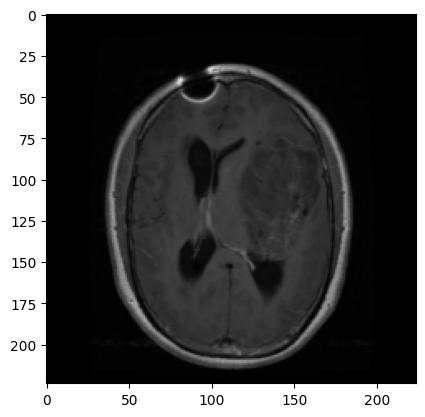

In [38]:
plt.imshow(cls_X[1])

In [34]:
img_path = cls_train_dataset.imgs[0][0]
img = Image.open(img_path).convert("RGB")
print(img.size)

(512, 512)


TypeError: Invalid shape (3, 224, 224) for image data

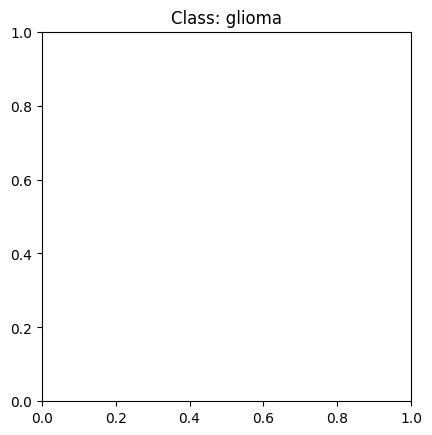

In [15]:
plt.title(f"Class: {cls_train_dataset.classes[cls_y[2]]}")
plt.imshow(cls_X[2])
plt.axis("off")
plt.show()

In [ ]:
cls_x_train, cls_x_test, cls_y_train, cls_y_test = train_test_split(cls_X, cls_y, test_size=0.2, random_state=42,stratify=cls_y)

In [ ]:
print(cls_x_train)

##Unet

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [ ]:
class UNetEncoder(nn.Module):
    def __init__(self, in_channels, first_out_channel=16):
        super().__init__()

        self.enc1 = ConvBlock(in_channels, first_out_channel)
        self.enc2 = ConvBlock(first_out_channel, first_out_channel*2)
        self.enc3 = ConvBlock(first_out_channel*2, first_out_channel*4)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #pooling layer can be reused as there are no learnable parameters

    def forward(self, x):
        x1 = self.enc1(x)              # 16 channels x 600
        x2 = self.enc2(self.pool(x1))  # 32 channels x 300
        x3 = self.enc3(self.pool(x2))  # 64 channels x 150

        return x1, x2, x3

In [ ]:
class UNetBottleneck(nn.Module):
  def __init__(self, in_channels):
    super().__init__()

    self.enc = ConvBlock(in_channels, in_channels*2)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    return self.enc(self.pool(x))

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()

        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(2*out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        #the 2*out_channels in the first conv is used to accomodate the skip connection

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([skip, x], dim=1)
        x = self.conv(x)
        return x

In [ ]:
class UNetDecoder(nn.Module):
    def __init__(self, in_channels = 128):
        super().__init__()

        self.decode1 = DecoderBlock(in_channels=in_channels, out_channels=in_channels//2)
        self.decode2 = DecoderBlock(in_channels=in_channels//2, out_channels=in_channels//4)
        self.decode3 = DecoderBlock(in_channels=in_channels//4, out_channels=in_channels//8)

        self.final_conv = nn.Conv2d(in_channels//8, 1, kernel_size=1)  # Output 1 channel for binary segmentation

    def forward(self, x4, x3, x2, x1):
        x3 = self.decode1(x4, x3) # 64 channels x 150
        x2 = self.decode2(x3, x2)  # 32 channels x 300
        x1 = self.decode3(x2, x1)  # 16 channels x 600
        x = self.final_conv(x1).squeeze(1) #1 channel x 600
        return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder = UNetEncoder(1, 8).to(device)
bottleneck = UNetBottleneck(32).to(device)
decoder = UNetDecoder(64).to(device)
#For each depth, the channel size doubles. Depth = 3 means a 3 times increase
#The bottleneck layer also doubles the channel size. Hence the total increase is 3+1 = 4

###training

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, epsilon=1.):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)  # raw logits to probabilities

        intersection = (preds * targets).sum()
        dice_loss = 1 - (2. * intersection + self.epsilon) / (preds.sum() + targets.sum() + self.epsilon)

        return dice_loss

In [ ]:
def calculate_iou(y_pred, y_true, threshold=0.5, eps=1e-6):
    y_pred = torch.sigmoid(y_pred)
    y_pred = (y_pred > threshold).float() #making it binaray

    y_pred = y_pred.view(y_pred.shape[0], -1)
    y_true = y_true.view(y_true.shape[0], -1)

    intersection = (y_pred * y_true).sum(dim = 1)
    union = y_pred.sum(dim = 1) + y_true.sum(dim = 1) - intersection

    # Compute IoU
    iou = (intersection + eps) / (union + eps)
    return iou.mean()

In [ ]:
# train_loader = BatchLoader(x_train, y_mask_train, y_train, shuffle = True, batch_size = 8, device = device)
# test_loader = BatchLoader(x_test, y_mask_test, y_test, shuffle = False, batch_size = 8, device = device)

###segmentations

In [ ]:
# optim = torch.optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr = 0.05) #AdamW is used for regularization
# dice_loss = DiceLoss()
# bce_loss = nn.BCEWithLogitsLoss()


# epochs = 5

# for epoch in range(epochs):
#     print(f"Epoch - {epoch + 1}")

#     train_bce_loss = 0
#     train_dice_loss = 0
#     train_iou = 0

#     encoder.train()
#     decoder.train()

#     for i in range(cls_x_train.len):
#         x, y_true = cls_x_train.next('classification')
#         x1, x2, x3 = encoder(x.unsqueeze(1))
#         x4 = bottleneck(x3)
#         y_predict = decoder(x4, x3, x2, x1)

#         bce = bce_loss(y_predict, y_true.float())
#         dice = dice_loss(y_predict, y_true)

#         #these weights may not give you the best results
#         loss = 0.2*bce + 0.8*dice

#         train_bce_loss += bce
#         train_dice_loss += dice
#         train_iou += calculate_iou(y_predict, y_true.float())

#         optim.zero_grad()
#         loss.backward()
#         optim.step()

#     print(f"Train BCE loss - {train_bce_loss/cls_x_train.len:4f} | Train Dice loss - {train_dice_loss/cls_x_train.len:4f} | Train IoU - {train_iou/cls_x_train.len:4f}")

#     test_bce_loss = 0
#     test_dice_loss = 0
#     test_iou = 0

#     encoder.eval()
#     decoder.eval()

#     with torch.no_grad():
#         for i in range(test_loader.len):
#             x, y_true = test_loader.next('segmentation')
#             x1, x2, x3 = encoder(x.unsqueeze(1))
#             x4 = bottleneck(x3)
#             y_predict = decoder(x4, x3, x2, x1)

#             bce = bce_loss(y_predict, y_true.float())
#             dice = dice_loss(y_predict, y_true)

#             test_bce_loss += bce
#             test_dice_loss += dice
#             test_iou += calculate_iou(y_predict, y_true.float())

#     print(f"Test BCE loss - {test_bce_loss/test_loader.len:4f} | Test Dice loss - {test_dice_loss/test_loader.len:4f} | Test IoU - {test_iou/test_loader.len:4f}")
#     print("\n")

###classifications

In [ ]:
class Classifier(nn.Module):
    def __init__(self, in_channels = 32, num_classes = 3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels*2, 3)
        self.conv2 = nn.Conv2d(in_channels*2, in_channels, 3)
        self.conv3 = nn.Conv2d(in_channels, num_classes, 3)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2, stride = 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2, stride = 2)
        x = F.adaptive_avg_pool2d(self.conv3(x), (1, 1)).squeeze((-1,-2))

        return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_loader = DataLoader(cls_x_train, cls_y_train, shuffle = True, batch_size = 8, device = device)
test_loader = DataLoader(cls_x_test, cls_y_test, shuffle = False, batch_size = 8, device = device)

#instantiating U-Net
encoder = UNetEncoder(1, 8).to(device)
bottleneck = UNetBottleneck(32).to(device)
decoder = UNetDecoder(64).to(device)

#instantiating classifier
classifier = Classifier(64).to(device)

#optimizer needs the parameters from both the U-Net and classifier networks
optim = torch.optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr = 0.005)
dice_loss = DiceLoss()
bce_loss = nn.BCEWithLogitsLoss()

#class weights can be added for the classification part to get better training in imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

#classifier will need multi cross entropy as there are 3 classes
classifier_loss_fn = nn.CrossEntropyLoss(weight = class_weights.to(device))

epochs = 25

for epoch in range(epochs):
    print(f"Epoch - {epoch + 1}")

    train_bce_loss = 0
    train_dice_loss = 0
    train_iou = 0
    train_classifier_loss = 0
    train_correct = 0
    train_samples = 0

    encoder.train()
    decoder.train()

    for i in range(train_loader.len):
        x, y_label= train_loader.next('classification')
        x1, x2, x3 = encoder(x.unsqueeze(1))
        x4 = bottleneck(x3)
        y_predict_mask = decoder(x4, x3, x2, x1)
        y_predict_label = classifier(x4)

        bce = bce_loss(y_predict_mask)
        dice = dice_loss(y_predict_mask)
        classifier_loss = classifier_loss_fn(y_predict_label, y_label)

        #these weights may not give you the best results
        loss = (0.2*bce + 0.8*dice)/2 + 0.5*classifier_loss

        train_bce_loss += bce
        train_dice_loss += dice
        train_iou += calculate_iou(y_predict_mask)
        train_classifier_loss += classifier_loss
        train_correct += (y_predict_label.argmax(dim = 1) == y_label).sum().item()
        train_samples += y_label.shape[0]

        optim.zero_grad()
        loss.backward()
        optim.step()

    print(f"Train BCE loss - {train_bce_loss/train_loader.len:4f}")
    print(f"Train Dice loss - {train_dice_loss/train_loader.len:4f}")
    print(f"Train IoU - {train_iou/train_loader.len:4f}")
    print(f"Train Classifier loss - {train_classifier_loss/train_loader.len:4f}")
    print(f"Train accuracy - {train_correct/train_samples:4f}")

    test_bce_loss = 0
    test_dice_loss = 0
    test_iou = 0
    test_classifier_loss = 0
    test_correct = 0
    test_samples = 0

    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        for i in range(test_loader.len):
            x, y_label  = test_loader.next('classification')
            x1, x2, x3 = encoder(x.unsqueeze(1))
            x4 = bottleneck(x3)
            y_predict_mask = decoder(x4, x3, x2, x1)
            y_predict_label = classifier(x4)

            bce = bce_loss(y_predict_mask)
            dice = dice_loss(y_predict_mask, )
            classifier_loss = classifier_loss_fn(y_predict_label, y_label)

            test_bce_loss += bce
            test_dice_loss += dice
            test_iou += calculate_iou(y_predict_mask)
            test_classifier_loss += classifier_loss
            test_correct += (y_predict_label.argmax(dim = 1) == y_label).sum().item()
            test_samples += y_label.shape[0]

        print(f"\nTest BCE loss - {test_bce_loss/test_loader.len:4f}")
        print(f"Test Dice loss - {test_dice_loss/test_loader.len:4f}")
        print(f"Test IoU - {test_iou/test_loader.len:4f}")
        print(f"Test Classifier loss - {test_classifier_loss/test_loader.len:4f}")
        print(f"Test accuracy - {test_correct/test_samples:4f}\n")

TypeError: DataLoader.__init__() got multiple values for argument 'batch_size'